In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import re
from anndata import AnnData
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KDTree
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [3]:
def stereo_loc(adata):
    adata.obs['x'] = adata.obs_names.map(lambda x : int(x.split('_')[1]))
    adata.obs['y'] = adata.obs_names.map(lambda x : int(x.split('_')[2]))
    adata.obsm['spatial'] = adata.obs[['x','y']].values
    return adata

def read2sample(align,sample):
    read = pd.read_csv(align)
    read['sample'] = sample
    return dict(zip(read['descrsR1'],read['sample']))

def get_Hits(x):
    if isinstance(x,float):
        return 'NA'
    return re.sub(r'\(.*?\)', '', x)

############################################################
#### process mixcr align tsv for adata  
############################################################
def process_align(align,binsize = 50):
    align = align[['readId','descrsR1','topChains','allVHitsWithScore','allDHitsWithScore','allJHitsWithScore','allCHitsWithScore','cloneId']].copy()
    for typ in ['V','D','J','C']:
        align[f'{typ}Hits'] = align[f'all{typ}HitsWithScore'].apply(get_Hits)
    align = align[['readId','descrsR1','topChains','VHits','DHits','JHits','CHits','cloneId']].copy()
    codon_align = align[align['readId'].map(lambda x : ',' in x )].copy()
    rest_align = align[align['readId'].map(lambda x : ',' not in x )]
    codon_align = codon_align.apply(lambda x: pd.DataFrame({'readId': x['readId'].split(','),'descrsR1': x['descrsR1'].split(','),'topChains': [x['topChains']] * len(x['readId'].split(',')),'VHits': [x['VHits']] * len(x['readId'].split(',')),'DHits': [x['DHits']] * len(x['readId'].split(',')),'JHits': [x['JHits']] * len(x['readId'].split(',')),'cloneId': [x['cloneId']] * len(x['readId'].split(','))}), axis=1).tolist()
    codon_align = pd.concat(codon_align).reset_index(drop=True)
    align = pd.concat([rest_align,codon_align],axis = 0,ignore_index=True)
    align['x'] = align['descrsR1'].apply(lambda x: x.split(':Z:')[1].split('_')[0])
    align['y'] = align['descrsR1'].apply(lambda x: x.split(':Z:')[1].split('_')[1])
    align['binx'] = align['x'].map(int)//binsize*binsize
    align['biny'] = align['y'].map(int)//binsize*binsize
    align['dnb'] = align['binx'].map(str) + '_' + align['biny'].map(str)
    return align

############################################################
#### mixcr align tsv bulid adata   # need process align
############################################################

def bulid_imudata(subalign,rna):
    subalign = subalign[['spot','cloneId','descrsR1']].groupby(['spot','cloneId']).count().reset_index()
    subalign['descrsR1'] = 1
    pivotdf = pd.pivot_table(subalign,index = 'spot',columns  = 'cloneId',values = 'descrsR1').fillna(0)
    adata = AnnData(csr_matrix(pivotdf))
    adata.obs_names = pivotdf.index
    adata.var_names = [str(i) for i in pivotdf.columns]
    rna_spot = rna.obs_names
    xcr_spot = adata.obs_names

    xcr_spot = xcr_spot.intersection(rna_spot)
    rest_spot = set(rna_spot) - set(xcr_spot)

    rest_adata = AnnData(csr_matrix(np.zeros([len(rest_spot),adata.shape[1]])))
    rest_adata.obs_names = rest_spot
    rest_adata.var_names = adata.var_names
    adata = adata[adata.obs_names.isin(xcr_spot)].copy()
    imudata = sc.concat([adata,rest_adata])
    imudata = imudata[rna.obs_names].copy()
    imudata.obsm['spatial'] = rna.obsm['spatial']
    return imudata


############################################################
#### mixcr clone tsv add mutation
############################################################
def addmutationinfo(mixcr_clone):
    def mutation_extract(Alignments_str,target):
        queryLength_list = []
        mutation_freq_list = []
        alignmentScore_list = []
        Alignments = Alignments_str.split(';')[0]
        info = Alignments.split('|')
        queryLength = int(info[4]) - int(info[3])
        mutations = info[5]
        alignmentScore = float(info[6])
        subs = mutations.count('S')
        dels =  mutations.count('D')
        ins = mutations.count('I')
        mutation_freq = subs + dels + ins
        queryLength_list.append(queryLength)
        mutation_freq_list.append(mutation_freq)
        alignmentScore_list.append(alignmentScore)

        queryLength_sum = sum(queryLength_list)
        mutation_freq_sum = sum(mutation_freq_list)
        if queryLength_sum != 0:
            mutation_perc = mutation_freq_sum / queryLength_sum
        else:
            mutation_perc = 0
        return queryLength_sum,mutation_freq_sum,mutation_perc,np.median(alignmentScore_list)

    def bulid_mutation_df(row):

        j_align = row['allJAlignments']
        target = row['targetSequences']
        jql,jmf,jmp,js = mutation_extract(j_align,target)

        v_align = row['allVAlignments']
        vql,vmf,vmp,vs = mutation_extract(v_align,target)

        tmp = pd.DataFrame(
            {
                'J_target_length':[jql],
                'J_mutation_freq':jmf,
                'J_mutation_perc':jmp,
                'V_target_length':len(target),
                'V_query_length':vql,
                'V_mutation_freq':vmf,
                'V_mutation_perc':vmp,
                'V_qual':vs,
            })
        return tmp
    
    
    cln = mixcr_clone.copy()
    cln = cln[cln['topChains'].isin(['IGK','IGL','IGH'])].reset_index(drop=True).copy()
    tmp_list = [] 
    for idx,row in cln.iterrows():
        tmp = bulid_mutation_df(row)
        tmp_list.append(tmp)
    mutation_df = pd.concat(tmp_list,ignore_index=True)
    mutation_df['mutated'] = (mutation_df['J_mutation_freq'] +  mutation_df['V_mutation_freq'])>0
    cln = pd.concat([cln,mutation_df],axis = 1)
    cln['mutation'] = cln['J_mutation_freq'] + cln['V_mutation_freq'] 
    return cln


############################################################
#### plot seq
############################################################

from Bio.Align.Applications import ClustalwCommandline
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Align import AlignInfo
from Bio import AlignIO
import seqlogo

def plot_seqlogo(seqs,return_consensus = False):
    seqs = [ seq.replace('-','_') for seq in seqs]
    amino_acids = "ACDEFGHIKLMNPQRSTVWYX*_"
    freq_matrix = {aa: [0] * len(seqs[0]) for aa in amino_acids}
    for seq in seqs:
        for i, aa in enumerate(seq):
            if aa in freq_matrix:
                freq_matrix[aa][i] += 1
    total_seqs = len(seqs)
    freq_matrix = {aa: [count/total_seqs for count in counts] for aa, counts in freq_matrix.items()}
    freq_df = pd.DataFrame(freq_matrix, index=range(1, len(seqs[0])+1))
    FreqSeqLogo= seqlogo.Ppm(freq_df,alphabet_type="reduced AA",background = 0.1)
    if return_consensus:
        consensus = ""
        for i in range(FreqSeqLogo.ppm.shape[0]):
            tmp = FreqSeqLogo.ppm.iloc[i]
            if tmp[tmp>0.5].shape[0] ==0:
                consensus += "X"
            else:
                base = tmp[tmp>0.5].index[0]
                consensus+=base
        return consensus
    image = seqlogo.seqlogo(FreqSeqLogo, ic_scale = False,format = 'png',size = 'small',color_scheme = 'monochrome')
    return image

def align_seq(protein_sequences,out_prefix,max_lenth = None,plot = True,return_df = False,return_consensus = False):
    if max_lenth != None:
        protein_sequences = [i for i in protein_sequences if len(i) <= max_lenth]
    def write_fasta(sequences, filename="sequences.fasta"):
        seq_records = [SeqRecord(Seq(seq), id=f"Seq{i+1}", description="") for i, seq in enumerate(sequences)]
        SeqIO.write(seq_records, filename, "fasta")
        return filename
    fasta_file = write_fasta(protein_sequences)
    clustalw_exe = "/home/liuyi/02.software/clustalw/clustalw-2.1-linux-x86_64-libcppstatic/clustalw2"
    clustalw_cline = ClustalwCommandline(clustalw_exe, infile=fasta_file)
    clustalw_cline()
    alignments = AlignIO.read("sequences.aln", "clustal")
    alignment_list = []
    for alignment in alignments:
        alignment_list.append(str(alignment.seq))
    if return_df:
        return pd.DataFrame(alignment_list)
    if return_consensus:
        return plot_seqlogo(alignment_list,return_consensus = True)
    else:
        pd.DataFrame(alignment_list).to_csv(f'./aa_seqlogo/{out_prefix}.csv',index=None,header=None)
    if plot:
        image = plot_seqlogo(alignment_list)
        return image
    
    
############################################################
#### distance plot
############################################################
    
def distance_plot(in_adata,feature,step = 10,k = 10,max_distance = 600,ax = None,return_r = False,return_df = False,tree = None,query = None):
    adata = in_adata.copy()
    if feature not in adata.obs.columns:
        adata.obs[feature] = adata[:,feature].to_df()
    if tree == None:
        tree = KDTree(adata.obsm['spatial'][adata.obs['tb_plot']=='tb',:])
    if query == None:
        query = tree.query(adata.obsm['spatial'][adata.obs['tb_plot']=='other',:], k = k)
    
    count = adata.obs.loc[adata.obs['tb_plot']=='other',[feature]]
    count['dist']= query[0].mean(axis=1)
    count = count[count['dist'] < max_distance]
    count['dist_range'] = count['dist'].apply(lambda x: int(x/step)*step)
    df_mean = count.groupby('dist_range').mean()
    df_mean = df_mean.reset_index()
    if return_df:
        return df_mean
    pearsonr_corr, p_value = pearsonr(df_mean['dist'], df_mean[feature])
    if return_r:
        return spearman_corr, p_value
    sns.scatterplot(data=df_mean, x='dist_range', y=feature, s=5, color='grey', ax=ax, edgecolor='none')
    ax.grid(False)
    ax.set_xlabel('Distance')
    coefficients = np.polyfit(df_mean['dist_range'], df_mean[feature], 1)
    polynomial = np.poly1d(coefficients)
    x_values = np.linspace(df_mean['dist_range'].min(), df_mean['dist_range'].max(), 100)
    y_values = polynomial(x_values)
    ax.plot(x_values, y_values, color='red')
    text_x = ax.get_xlim()[0] - ax.get_xlim()[1]/10
    text_y = ax.get_ylim()[1] - ax.get_ylim()[1]/10
    ax.text(text_x, text_y, f'r = {pearsonr_corr:.2f}\np = {p_value:.2e}', fontsize = 8, va='top')
    ax.invert_xaxis()

# 4w

In [4]:
adata = sc.read_h5ad('/storage/liuyi/08.stereo_v2/new_bcr/assemble/4w.lasso.h5ad')

## load align file

In [5]:
raw_align = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/lung_4w/lung_4w.align.tsv',sep = '\t', low_memory=False)
raw_align = process_align(raw_align)

In [6]:
totalreads = {}
align_file_dict = {
    "Y00583F1":'/storage/liuyi/08.stereo_v2/new_bcr/assemble/Y00583F1.align.tsv',
    "Y00583F6":'/storage/liuyi/08.stereo_v2/new_bcr/assemble/Y00583F6.align.tsv'
}
for name,align_file in align_file_dict.items():
    reads = read2sample(align_file,name)
    totalreads.update(reads)

In [7]:
raw_align['sample'] = raw_align['descrsR1'].map(totalreads)
raw_align['spot'] = raw_align['sample'] + '@' + raw_align['dnb']

## load clone file

In [8]:
mixcr_clone = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/lung_4w/lung_4w.contigs.tsv',sep = '\t')
bcr_clone = addmutationinfo(mixcr_clone)
chainsdict = dict(zip(mixcr_clone['cloneId'].map(str),mixcr_clone['topChains']))
cdr3dict = dict(zip(mixcr_clone['cloneId'].map(str),mixcr_clone['aaSeqCDR3']))
mutationvaluedict = dict(zip(bcr_clone['cloneId'].map(str),bcr_clone['mutation']))
mutationdict = dict(zip(bcr_clone['cloneId'].map(str),bcr_clone['mutated']))

## bulid XCR adata

In [9]:
imudata = bulid_imudata(raw_align[raw_align['cloneId'] != -1],adata)

In [10]:
imudata.var['chain'] = imudata.var_names.map(chainsdict)
imudata.var['cdr3'] = imudata.var_names.map(cdr3dict)
imudata.var['mutated'] = imudata.var_names.map(mutationdict)
imudata.var['mutation'] = imudata.var_names.map(mutationvaluedict)
sc.pp.filter_genes(imudata,min_cells = 1)
imudata.obs['IGK'] = np.sum(imudata[:,imudata.var['chain'] == 'IGK'].X,axis = 1)
imudata.obs['IGL'] = np.sum(imudata[:,imudata.var['chain'] == 'IGL'].X,axis = 1)
imudata.obs['IGH'] = np.sum(imudata[:,imudata.var['chain'] == 'IGH'].X,axis = 1)

In [13]:
# imudata.write('4w.imudata.h5ad')

## V gene

In [15]:
def getvtype(x):
    for i in ['IGHV','IGKV','IGLV']:
        if x.startswith(i):
            return i
vgene = raw_align['VHits'].apply(lambda x : x.split(',')[0].split('*')[0]).to_frame()
vgene = vgene[vgene['VHits']!='NA'].copy()
vgene['vtype'] = vgene['VHits'].apply(getvtype)
vgene = vgene.drop_duplicates('VHits')
value_counts = vgene['vtype'].value_counts()

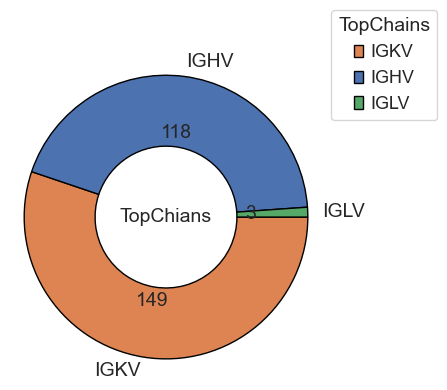

In [16]:
sizes = value_counts.values
labels = value_counts.index
total_value = sizes.sum()
def absolute_value(val):
    total = sum(sizes)
    return int(val/100.*total)
colors = sns.color_palette('deep',n_colors= 3)[1],sns.color_palette('deep',n_colors= 3)[0],sns.color_palette('deep',n_colors= 3)[2]
fig, ax = plt.subplots(figsize = (4,4))
ax.pie(sizes, labels=labels, startangle=0,colors = colors, counterclock=False,autopct=lambda p: f'{absolute_value(p)}',wedgeprops=dict(width=0.5,edgecolor='black'))
ax.axis('equal')
ax.text(0, 0, f'TopChians', ha='center', va='center')
ax.legend(title='TopChains', loc='center left', bbox_to_anchor=(1, 0, 0.5, 2))
plt.show()

## clone assemble

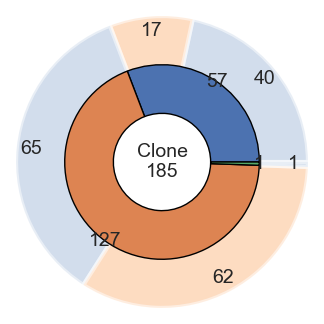

In [17]:
t = imudata.var.copy()
df = t[['chain','mutated']]

out_list = []
in_list = []
labels = []
for idx,tmp in df.groupby('chain'):
    in_list.append(tmp['mutated'].count())
    for value in tmp['mutated'].value_counts():
        out_list.append(value)
    labels.append(idx)

value_counts = df['chain'].value_counts()
sizes = value_counts.values
def absolute_value(pct):
    total = sum(sizes)
    return int(round(pct*total/100.0))


inner_colors = np.array(sns.color_palette('deep')[0:3])
outer_colors = np.array([[166,189,219],[253,187,132],[166,189,219],[253,187,132],[166,189,219],[253,187,132]])/255
fig,ax = plt.subplots(figsize = (4,4))
ax.pie(out_list,autopct=lambda p: f'{absolute_value(p)}',radius=1.2,pctdistance=0.9,wedgeprops=dict(linewidth=3,width=0.5,edgecolor='w',alpha = 0.5),colors = outer_colors)
ax.pie(in_list,autopct=lambda p: f'{absolute_value(p)}',radius=0.8,pctdistance=1,wedgeprops=dict(linewidth=1,width=0.4,edgecolor='black'),colors= inner_colors)
count = t['chain'].count()
ax.text(0, 0, f'Clone\n{count}', ha='center', va='center')
plt.show()

In [18]:
# imudata.var[['chain','cdr3']].to_csv('4w.bcr.csv',index=None)

## clone

In [19]:
# imudata = sc.read_h5ad('4w.imudata.h5ad')

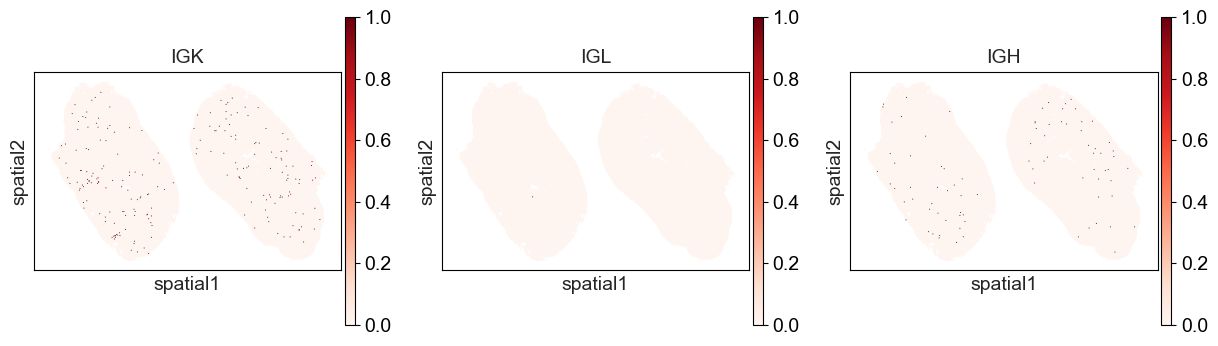

In [20]:
sc.pl.spatial(imudata , color = ['IGK','IGL','IGH'],basis = 'spatial',spot_size= 90,cmap = 'Reds',vmax = 1)#save = '4w.isotype.pdf')

## bin50

In [21]:
imudata.obs['region'] = adata.obs['region']
subadata = imudata[imudata.obs['region'] == 'Infection']
bcr_align = raw_align[raw_align['cloneId'] != -1].copy()
bcr_align[['x','y']] = bcr_align[['x','y']].astype(int)
n2align = bcr_align[bcr_align['sample'] == 'Y00583F1'].copy()
n6align = bcr_align[bcr_align['sample'] == 'Y00583F6'].copy()
bcr_align = pd.concat([n2align,n6align],ignore_index=True)
imudata.obs['BCR'] = (imudata.obs_names.isin(bcr_align['spot']))
imudata.obs['BCR'] = imudata.obs['BCR'].map({True:'BCR',False:'Other'})
bcradata = imudata[imudata.obs['BCR'] == 'BCR']

In [22]:
tb_loc = subadata.obsm['spatial']
bcr_loc = bcradata.obsm['spatial']
totol_loc = imudata.obsm['spatial']

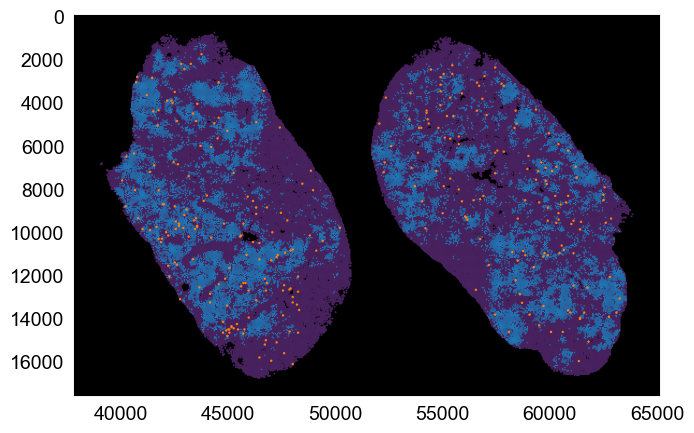

In [23]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
fig,ax = plt.subplots(figsize = (7.5,5))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],s = 2,edgecolor = 'None',ax = ax,color = '#47225E',rasterized =True)
sns.scatterplot(x = tb_loc[:,0],y = tb_loc[:,1],s = 1,edgecolor = 'None',ax = ax,rasterized =True)
sns.scatterplot(x = bcr_loc[:,0],y = bcr_loc[:,1],s = 3,edgecolor = 'None',ax = ax,rasterized =True)
ax.invert_yaxis()
ax.grid(False)
fig.show()

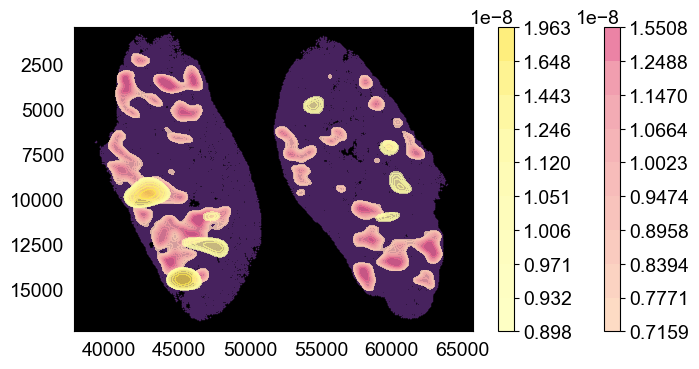

In [24]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
r_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#feffae', '#fee434'], N=256)#ye

fig,ax = plt.subplots(figsize = (8,4))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],edgecolor = None, ax = ax ,s = 1,rasterized =True,color = '#47225E',)
sns.kdeplot(x = tb_loc[:,0], y = tb_loc[:,1],cmap=cmap,fill=True,bw_adjust = 0.25,thresh = 0.5,alpha =.8,legend=False,cbar = True,cbar_ax=None,ax = ax)
sns.kdeplot(x = bcr_loc[:,0], y = bcr_loc[:,1],cmap=r_cmap,fill=True,bw_adjust = 0.3,thresh = 0.85,alpha =.7,legend=False,cbar = True,cbar_ax=None,ax = ax)
ax.invert_yaxis()
ax.grid(False)
fig.show()

# 8w

In [31]:
adata = sc.read_h5ad('/storage/liuyi/08.stereo_v2/new_bcr/assemble/8w.lasso.h5ad')

## load align file

In [32]:
raw_align = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/lung_8w/lung_8w.align.tsv',sep = '\t', low_memory=False)
raw_align = process_align(raw_align)

In [33]:
totalreads = {}
align_file_dict = {
    "Y00583N6":'/storage/liuyi/08.stereo_v2/new_bcr/assemble/Y00583N6.align.tsv',
    "Y00583N2":'/storage/liuyi/08.stereo_v2/new_bcr/assemble/Y00583N2.align.tsv'
}
for name,align_file in align_file_dict.items():
    reads = read2sample(align_file,name)
    totalreads.update(reads)
    
raw_align['sample'] = raw_align['descrsR1'].map(totalreads)
raw_align['spot'] = raw_align['sample'] + '@' + raw_align['dnb']

## load clone file

In [34]:
mixcr_clone = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/lung_8w/lung_8w.contigs.tsv',sep = '\t')
bcr_clone = addmutationinfo(mixcr_clone)
chainsdict = dict(zip(mixcr_clone['cloneId'].map(str),mixcr_clone['topChains']))
cdr3dict = dict(zip(mixcr_clone['cloneId'].map(str),mixcr_clone['aaSeqCDR3']))
mutationvaluedict = dict(zip(bcr_clone['cloneId'].map(str),bcr_clone['mutation']))
mutationdict = dict(zip(bcr_clone['cloneId'].map(str),bcr_clone['mutated']))

## bulid XCR adata

In [35]:
imudata = bulid_imudata(raw_align[raw_align['cloneId'] != -1],adata)

In [36]:
imudata.obs['region'] = adata.obs['region']
imudata.var['chain'] = imudata.var_names.map(chainsdict)
imudata.var['cdr3'] = imudata.var_names.map(cdr3dict)
imudata.var['mutated'] = imudata.var_names.map(mutationdict)
imudata.var['mutation'] = imudata.var_names.map(mutationvaluedict)
sc.pp.filter_genes(imudata,min_cells = 1)

In [37]:
imudata.obs['IGK'] = np.sum(imudata[:,imudata.var['chain'] == 'IGK'].X,axis = 1)
imudata.obs['IGL'] = np.sum(imudata[:,imudata.var['chain'] == 'IGL'].X,axis = 1)
imudata.obs['IGH'] = np.sum(imudata[:,imudata.var['chain'] == 'IGH'].X,axis = 1)

In [38]:
clone_chains_dict = dict(zip(bcr_clone['cloneId'],bcr_clone['topChains']))

## V gene

In [39]:
vgene = raw_align['VHits'].apply(lambda x : x.split(',')[0].split('*')[0]).to_frame()
vgene = vgene[vgene['VHits']!='NA'].copy()
vgene['vtype'] = vgene['VHits'].apply(getvtype)
vgene = vgene.drop_duplicates('VHits')

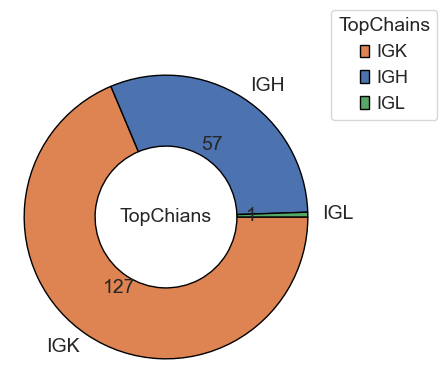

In [40]:
sizes = value_counts.values
labels = value_counts.index
total_value = sizes.sum()
colors = sns.color_palette('deep',n_colors= 3)[1],sns.color_palette('deep',n_colors= 3)[0],sns.color_palette('deep',n_colors= 3)[2]
fig, ax = plt.subplots(figsize = (4,4))
ax.pie(sizes, labels=labels, startangle=0,colors = colors, counterclock=False,autopct=lambda p: f'{absolute_value(p)}',wedgeprops=dict(width=0.5,edgecolor='black'))
ax.axis('equal')
ax.text(0, 0, f'TopChians', ha='center', va='center')
ax.legend(title='TopChains', loc='center left', bbox_to_anchor=(1, 0, 0.5, 2))
plt.show()

## clone assemble

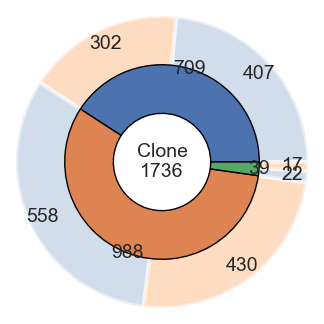

In [41]:
t = imudata.var.copy()
df = t[['chain','mutated']]

out_list = []
in_list = []
labels = []
for idx,tmp in df.groupby('chain'):
    in_list.append(tmp['mutated'].count())
    for value in tmp['mutated'].value_counts():
        out_list.append(value)
    labels.append(idx)

value_counts = df['chain'].value_counts()
sizes = value_counts.values
def absolute_value(pct):
    total = sum(sizes)
    return int(round(pct*total/100.0))


inner_colors = np.array(sns.color_palette('deep')[0:3])
outer_colors = np.array([[166,189,219],[253,187,132],[166,189,219],[253,187,132],[166,189,219],[253,187,132]])/255
fig,ax = plt.subplots(figsize = (4,4))
ax.pie(out_list,autopct=lambda p: f'{absolute_value(p)}',radius=1.2,pctdistance=0.9,wedgeprops=dict(linewidth=3,width=0.5,edgecolor='w',alpha = 0.5),colors = outer_colors)
ax.pie(in_list,autopct=lambda p: f'{absolute_value(p)}',radius=0.8,pctdistance=1,wedgeprops=dict(linewidth=1,width=0.4,edgecolor='black'),colors= inner_colors)
count = t['chain'].count()
ax.text(0, 0, f'Clone\n{count}', ha='center', va='center')
plt.show()

# clone 分布

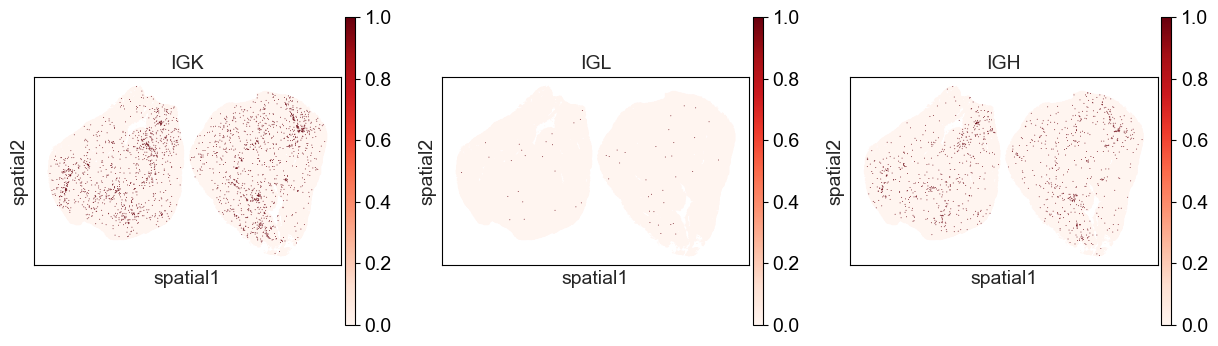

In [42]:
sc.pl.spatial(imudata , color = ['IGK','IGL','IGH'],basis = 'spatial',spot_size= 90,cmap = 'Reds',vmax = 1)

# overlap

In [43]:
from matplotlib_venn import venn2
bcr = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/TB_BCR.csv',sep= '\t')
bcr_4w = pd.read_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/4w.bcr.csv')
bcr_8w = imudata.var.drop_duplicates('cdr3')[['cdr3','chain']]
bcr_8w['cdr3_sequence'] = bcr_8w['cdr3'].astype(str) +'_' + (bcr_8w.groupby('cdr3').cumcount() + 1).astype(str)
bcr_4w['cdr3_sequence'] = bcr_4w['cdr3'].astype(str) +'_' + (bcr_4w.groupby('cdr3').cumcount() + 1).astype(str)

bcr['type'] = bcr['VGeneAllele'].apply(lambda x : x[:3])
bcr['cdr3_sequence'] = bcr['aaSeqCDR3']+'_' + (bcr.groupby('aaSeqCDR3').cumcount() + 1).astype(str)
dupbcr = bcr.drop_duplicates('aaSeqCDR3')
cdr3setdict = {'8w':set(bcr_8w['cdr3_sequence']),'4w':set(bcr_4w['cdr3_sequence']),'bcr':set(bcr['cdr3_sequence'])}

/tmp/ipykernel_421963/1349120423.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bcr_8w['cdr3_sequence'] = bcr_8w['cdr3'].astype(str) +'_' + (bcr_8w.groupby('cdr3').cumcount() + 1).astype(str)


In [44]:
aa_seq = imudata.var['cdr3']
bcr_list = dupbcr['aaSeqCDR3']
common_index = set(aa_seq).intersection(set(bcr_list))
print(common_index)

{'CQQWSSNPLTF', 'CQQHYSTPPTF', 'CWQGTHFPRTF', 'CQQYYSYPLTF', 'CQQYYRYPLTF', 'CQQHYSTPWTF', 'CQQHYSTPLTF', 'CQNDHSYPYTF', 'CKQSYNLYTF', 'CSQSTHVPWTF', 'CQQWSSNPPTF', 'CQNDHSYPLTF', 'CMQHLEYPLTF', 'CQQWSGNPLTF', 'CQQLVEYPLTF', 'CQQGSSIPFTF', 'CWQGTHFPYTF', 'CQQNNEDPLTF', 'CQQSKEVPRTF', 'CVQYAQFPRTF', 'CQHSRELPWTF'}


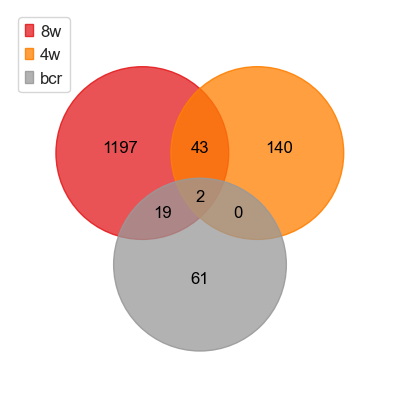

In [45]:
from venn import venn
fig,ax = plt.subplots(figsize = (5,5))
venn(cdr3setdict, cmap = 'Set1',alpha = 0.75, fontsize=12, legend_loc="upper left",ax = ax)
fig.show()

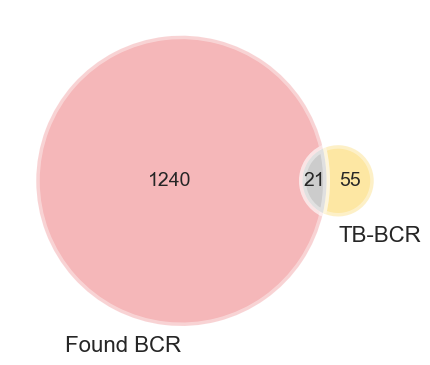

In [46]:
fig,ax = plt.subplots(figsize=(5, 5))
aa_seq = imudata.var['cdr3']
venn = venn2([set(aa_seq), set(bcr_list)], ('Found BCR', 'TB-BCR'),ax = ax)
venn.get_patch_by_id('10').set_color('#e84b50') 
venn.get_patch_by_id('01').set_color('#fac319') 
try:
    venn.get_patch_by_id('11').set_color('grey') 
    position = ['10', '01', '11']
except:
    position = ['10', '01']
for text in venn.set_labels:
    text.set_fontsize(16)
for ridx in position:
    venn.get_patch_by_id(ridx).set_edgecolor('white') 
    venn.get_patch_by_id(ridx).set_linewidth(5)
fig.show()

In [47]:
sankeydf = pd.concat([bcr_4w['chain'].value_counts(),bcr_8w['chain'].value_counts()],axis = 1)
sankeydf.columns = ['4w','8w']
# sankeydf.to_csv('chains.stat.csv')

## bin50

In [68]:
imudata.obs['region'] = adata.obs['region']
subadata = imudata[imudata.obs['region'] == 'Infection']
bcr_align = raw_align[raw_align['cloneId'] != -1].copy()
bcr_align[['x','y']] = bcr_align[['x','y']].astype(int)
n2align = bcr_align[bcr_align['sample'] == 'Y00583N6'].copy()
n6align = bcr_align[bcr_align['sample'] == 'Y00583N2'].copy()
bcr_align = pd.concat([n2align,n6align],ignore_index=True)
imudata.obs['BCR'] = (imudata.obs_names.isin(bcr_align['spot']))
imudata.obs['BCR'] = imudata.obs['BCR'].map({True:'BCR',False:'Other'})
bcradata = imudata[imudata.obs['BCR'] == 'BCR']

In [69]:
tb_loc = subadata.obsm['spatial']
bcr_loc = bcradata.obsm['spatial']
totol_loc = imudata.obsm['spatial']

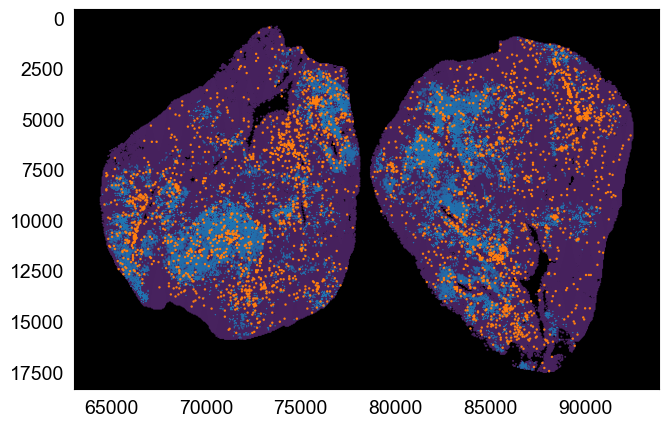

In [70]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
fig,ax = plt.subplots(figsize = (7.5,5))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],s = 2,edgecolor = 'None',ax = ax,color = '#47225E',rasterized =True)
sns.scatterplot(x = tb_loc[:,0],y = tb_loc[:,1],s = 1,edgecolor = 'None',ax = ax,rasterized =True)
sns.scatterplot(x = bcr_loc[:,0],y = bcr_loc[:,1],s = 3,edgecolor = 'None',ax = ax,rasterized =True)
ax.invert_yaxis()
ax.grid(False)
fig.show()

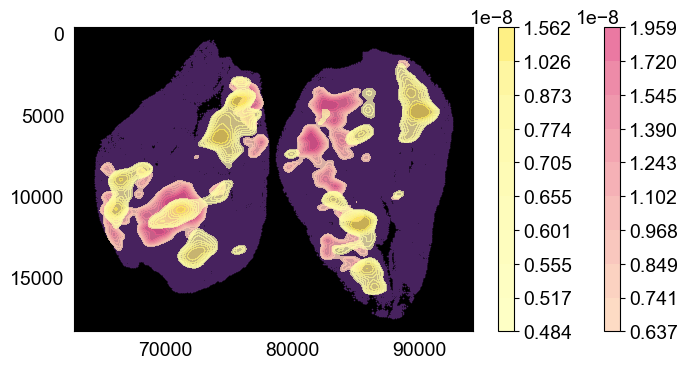

In [71]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
r_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#feffae', '#fee434'], N=256)#ye

fig,ax = plt.subplots(figsize = (8,4))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],edgecolor = None, ax = ax ,s = 1,rasterized =True,color = '#47225E',)
sns.kdeplot(x = tb_loc[:,0], y = tb_loc[:,1],cmap=cmap,fill=True,bw_adjust = 0.25,thresh = 0.4,alpha =.8,legend=False,cbar = True,cbar_ax=None,ax = ax)
sns.kdeplot(x = bcr_loc[:,0], y = bcr_loc[:,1],cmap=r_cmap,fill=True,bw_adjust = 0.3,thresh = 0.6,alpha =.7,legend=False,cbar = True,cbar_ax=None,ax = ax)
ax.invert_yaxis()
ax.grid(False)
fig.show()

In [72]:
sc.pp.filter_cells(imudata,min_genes = 0)
x = imudata.X.todense() > 0
imudata.obs['mutation_count'] = np.dot(x.astype(int),imudata.var['mutation'].values).reshape(-1,1)

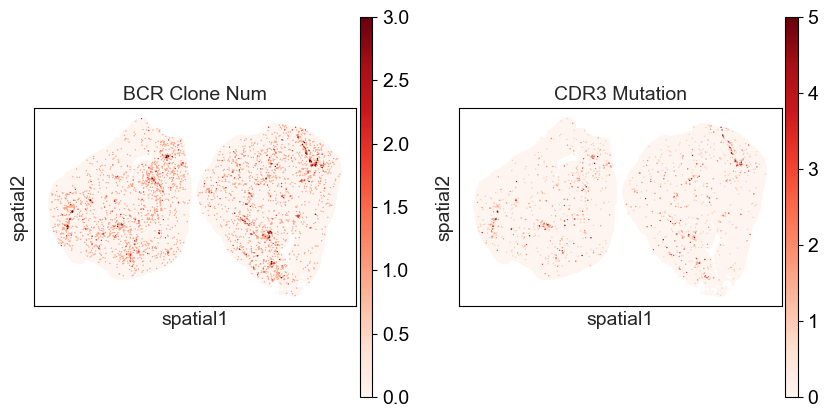

In [73]:
fig,axs = plt.subplots(1,2,figsize = (10,5))
for idx,i in enumerate(['n_genes','mutation_count']):
    if i == 'n_genes':
        title = 'BCR Clone Num'
    else:
        title = 'CDR3 Mutation'
    ax = axs[idx]
#     ax.set_facecolor('black')
    sc.pl.spatial(imudata,color = i,basis = 'spatial',spot_size = 130,title = title,ax = ax,vmax = 'p99.99',show = False,cmap = 'Reds')
fig.show()

In [74]:
imudata.obs['tb'] = imudata.obs['region'] == 'Infection'
imudata.obs['tb'] = imudata.obs['tb'].map({True:'tb',False:'other'})

In [75]:
def regplot(df, x, y,ax, hue=None, save=None, **kwds):
    sns.scatterplot(x=x, y=y, data=df,hue=hue,  
                    s=80, alpha=0.5, linewidth=0,ax = ax,color = '#FAC319', **kwds)
    sns.regplot(x=x, y=y, data=df, scatter=False,ax=ax,color = '#E84B50')

    r, p = pearsonr(df[x], df[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r2={:.2f}, p={:.2g}'.format(r**2, p),
            transform=ax.transAxes)
    ax.invert_xaxis()
    ax.grid(False)
    if save is not None:
        plt.savefig(save)
    plt.show()

def distance_plot(in_adata,feature,step = 10,k = 10,max_distance = 600,ax = None,return_r = False,return_df = False,tree = None,query = None):
    adata = in_adata.copy()
    if feature not in adata.obs.columns:
        adata.obs[feature] = adata[:,feature].to_df()
    if tree == None:
        tree = KDTree(adata.obsm['spatial'][adata.obs['tb']=='tb',:])
    if query == None:
        query = tree.query(adata.obsm['spatial'][adata.obs['tb']=='other',:], k = k)
    
    count = adata.obs.loc[adata.obs['tb']=='other',[feature]]
    count['dist']= query[0].mean(axis=1)
    count = count[count['dist'] < max_distance]
    count['dist_range'] = count['dist'].apply(lambda x: int(x/step)*step)
    df_mean = count.groupby('dist_range').mean()
    df_mean = df_mean.reset_index()
    if return_df:
        return df_mean
    pearsonr_corr, p_value = pearsonr(df_mean['dist'], df_mean[feature])
    if return_r:
        return spearman_corr, p_value
    regplot(df_mean,x = 'dist',y = feature,ax =ax)

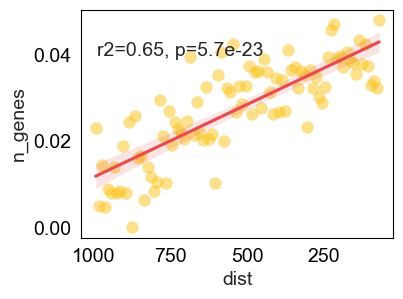

In [76]:
fig,ax = plt.subplots(figsize = (4,3))
distance_plot(imudata,'n_genes',step = 10,k = 10 ,max_distance = 1000,ax =ax)
fig.show()

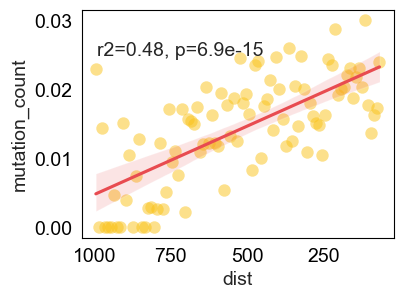

In [77]:
fig,ax = plt.subplots(figsize = (4,3))
distance_plot(imudata,'mutation_count',step = 10,k = 10 ,max_distance = 1000,ax =ax)
fig.show()

In [80]:
import Levenshtein
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram,set_link_color_palette
from scipy.spatial.distance import squareform
import radialtree as rt

def cluster_strings(series):
    n = len(series)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = Levenshtein.distance(series[i], series[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    Z = linkage(squareform(dist_matrix), 'complete')

    return Z

In [81]:
w4 = sc.read_h5ad('/storage/liuyi/08.stereo_v2/new_bcr/assemble/4w.imudata.h5ad')

# IGK

In [82]:
color_pal1 = ["#70f3ff",  "#44cef6",  "#3eede7",  "#1685a9",  "#177cb0",  "#065279",  "#003472",
  "#4b5cc4",  "#a1afc9",  "#2e4e7e",  "#3b2e7e",  "#4a4266",  "#426666",  "#425066",  "#574266", 
  "#8d4bbb",  "#815463",  "#815476",  "#4c221b",  "#003371",  "#56004f",  "#801dae",  "#4c8dae",
  "#b0a4e3",  "#cca4e3",  "#edd1d8",  "#e4c6d0",  "#ff461f",  "#ff2d51",  "#f36838",  "#ed5736",
  "#ff4777",  "#f00056",  "#ffb3a7",  "#f47983",  "#db5a6b",  "#c93756",  "#f9906f",  "#f05654",
  "#ff2121",  "#f20c00",  "#8c4356",  "#c83c23",  "#9d2933",  "#ff4c00",  "#ff4e20",  "#f35336",
  "#dc3023",  "#ff3300",  "#cb3a56",  "#a98175",  "#b36d61",  "#ef7a82",  "#ff0097",  "#c32136",
  "#be002f",  "#c91f37",  "#bf242a",  "#c3272b",  "#9d2933",  "#60281e",  "#622a1d",  "#bce672",
  "#c9dd22",  "#bddd22",  "#afdd22",  "#a3d900",  "#9ed900",  "#9ed048",  "#96ce54",  "#00bc12",
  "#0eb83a",  "#0eb83a",  "#0aa344",  "#16a951",  "#21a675",  "#057748",  "#0c8918",  "#00e500",
  "#40de5a",  "#00e079",  "#00e09e",  "#3de1ad",  "#2add9c",  "#2edfa3",  "#7fecad",  "#a4e2c6",
  "#7bcfa6",  "#1bd1a5",  "#48c0a3",  "#549688",  "#789262",  "#758a99",  "#50616d",  "#424c50",
  "#41555d",  "#eaff56",  "#fff143",  "#faff72",  "#ffa631",  "#ffa400",  "#fa8c35",  "#ff8c31",
  "#ff8936",  "#ff7500",  "#ffb61e",  "#ffc773",  "#ffc64b",  "#f2be45",  "#f0c239",  "#e9bb1d", 
  "#d9b611",  "#eacd76",  "#eedeb0",  "#d3b17d",  "#e29c45",  "#a78e44",  "#c89b40",  "#ae7000", 
  "#ca6924",  "#b25d25",  "#b35c44",  "#9b4400",  "#9c5333",  "#a88462",  "#896c39",  "#827100",  
  "#6e511e",  "#7c4b00",  "#955539",  "#845a33"]

color_pal1 = list(set(color_pal1))
import random
random.seed(62)

color_lists = random.sample(color_pal1,k = 36)
cluster_color_dict  = dict(zip(range(1,37),color_lists))

In [90]:
bcr_isotype = 'IGK'
subdata = imudata[:,imudata.var['chain']==bcr_isotype]
clonedf = subdata.var['cdr3'].drop_duplicates().to_frame().copy()
clonedf['type'] = 'A'
addbcr = bcr[bcr['type']==bcr_isotype]['aaSeqCDR3'].drop_duplicates().to_frame().rename({'aaSeqCDR3':'cdr3'},axis = 1)
addbcr['type'] = 'B'
sub4wdata = w4[:,w4.var['chain']==bcr_isotype]
add4w = sub4wdata.var['cdr3'].drop_duplicates().to_frame().copy()
add4w['type'] = 'C'
clonedf = pd.concat([clonedf,addbcr,add4w],ignore_index=True)
Z = cluster_strings(clonedf['cdr3'])

In [91]:
clonedf.to_csv('/storage/liuyi/08.stereo_v2/new_bcr/assemble/IGK_common.mouse.csv')

In [110]:
threshold = 7
clusters = fcluster(Z, threshold, criterion='distance')
rZ = dendrogram(Z,no_plot=True,color_threshold= threshold+0.1,labels=clonedf['cdr3'].to_list())
clonedf['cluster'] = clusters

In [111]:
def find_first_occurrences(labels):
    occurrences = {}
    last_label = None
    
    for idx, label in enumerate(labels):
        if label != last_label:
            if label not in occurrences:
                occurrences[label] = []
            occurrences[label].append(idx)
        last_label = label
    data = []
    for label, indices in occurrences.items():
        for idx in indices:
            data.append({'index': idx, 'label': label})
    df = pd.DataFrame(data)
    return df

In [112]:
before = ""
result_list = []
counter = {'C1': -1, 'C2': -1, 'C3': -1, 'C4': -1, 'C5': -1, 'C6': -1, 'C7': -1, 'C8': -1, 'C9': -1}
step_C = 0
for now in rZ['color_list']:
    if now == 'C0':
        result_list.append(now)
    else:
        if now != before:
            step_C += 1
        result_list.append(f'C{step_C}')
        before = now
rZ['color_list'] = result_list

In [113]:
plot_colors_dict = {
    'cdr3_type':np.array(clonedf['type'].map(colors_dict).tolist()),
    'cluster_type':np.array(clonedf['cluster'].map(cluster_color_dict).tolist())
                   }

plot_colors_legends = {'cdr3_type': 
                       {'colors':np.array(list(colors_dict.values())),'labels':list(colors_dict.keys())},
                        'cluster_type':
                        {'colors':np.array(list(cluster_color_dict.values())),'labels':list(cluster_color_dict.keys())}
                      }

0.3
1.3
['#5471AB' '#FAC319' '#D75755']
['#eacd76' '#ff461f' '#ff0097' '#ff4c00' '#c89b40' '#622a1d' '#3b2e7e'
 '#bce672' '#177cb0' '#8c4356' '#c3272b' '#cca4e3' '#815463' '#16a951'
 '#9b4400' '#ffa400' '#9ed048' '#eaff56' '#b35c44' '#1685a9' '#f00056'
 '#4c221b' '#fff143' '#c83c23' '#7bcfa6' '#44cef6' '#b36d61' '#ff8936'
 '#d3b17d' '#40de5a' '#0c8918' '#00e079' '#70f3ff' '#c91f37' '#48c0a3'
 '#4b5cc4']


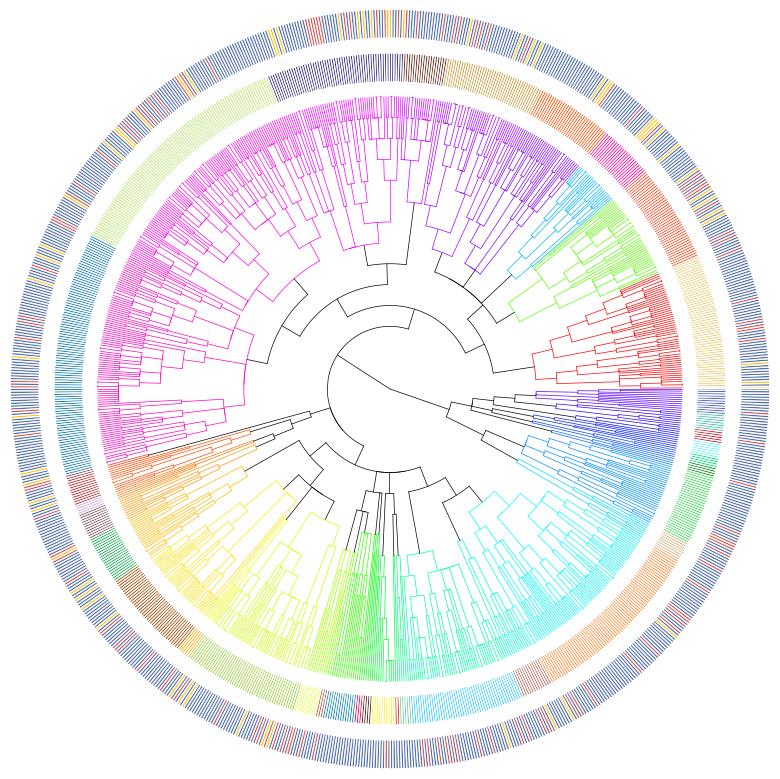

In [114]:
fig,ax = plt.subplots(figsize = (10,10))
rt.radialTreee(rZ,fontsize = 8,ax=ax,colorlabels = plot_colors_dict,colorlabels_legend =plot_colors_legends,addlabels =False)
fig.show()

In [131]:
clusterdf = clonedf[clonedf['cluster'] == 7]

In [132]:
# clusterdf = clonedf[clonedf['cluster'] == clonedf['cluster'].value_counts().index[0]]

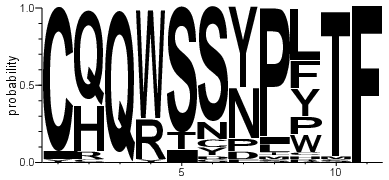

In [133]:
protein_sequences = clusterdf[clusterdf['type'] == 'A']['cdr3']
align_seq(protein_sequences,'cluster_A',max_lenth = 11,plot = True)

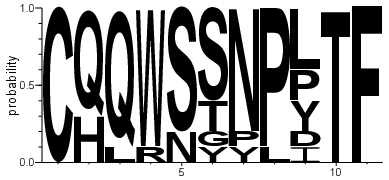

In [134]:
protein_sequences = clusterdf[clusterdf['type'] == 'B']['cdr3']
align_seq(protein_sequences,'cluster_B',max_lenth = 11,plot = True)

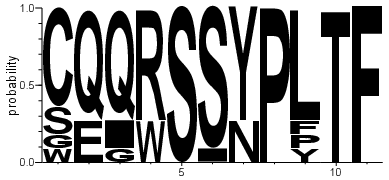

In [135]:
protein_sequences = clusterdf[clusterdf['type'] == 'C']['cdr3']
align_seq(protein_sequences,'cluster_C',max_lenth = 11,plot = True)

In [69]:
imudata.obs['known_cluster'] = np.sum(imudata[:,imudata.var['cdr3'].isin(clusterdf[clusterdf['type'] == 'A']['cdr3'])].X,axis = 1)
imudata.obs['known_clone'] = np.sum(imudata[:,imudata.var['cdr3'].isin(clusterdf[clusterdf['type'] == 'B']['cdr3'])].X,axis = 1)

In [70]:
known_8w_adata = imudata[imudata.obs['known_cluster']>0]
known_8w_loc = known_8w_adata.obsm['spatial']
known_adata = imudata[imudata.obs['known_clone']>0]
known_loc = known_adata.obsm['spatial']

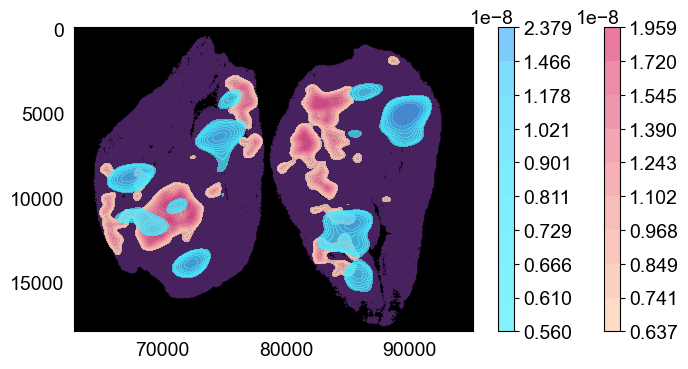

In [71]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)   #red
r_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#4AF0FE', '#44A0FD'], N=256) #blue

fig,ax = plt.subplots(figsize = (8,4))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],edgecolor = None, ax = ax ,s = 1,rasterized =True,color = '#47225E',)
sns.kdeplot(x = tb_loc[:,0], y = tb_loc[:,1],cmap=cmap,fill=True,bw_adjust = 0.25,thresh = 0.4,alpha =.8,legend=False,cbar = True,cbar_ax=None,ax = ax)

sns.kdeplot(x = known_8w_loc[:,0], y = known_8w_loc[:,1],cmap=r_cmap,fill=True,bw_adjust = 0.3,thresh = 0.6,alpha =.7,legend=False,cbar = True,cbar_ax=None,ax = ax)
ax.invert_yaxis()
ax.grid(False)
fig.show()

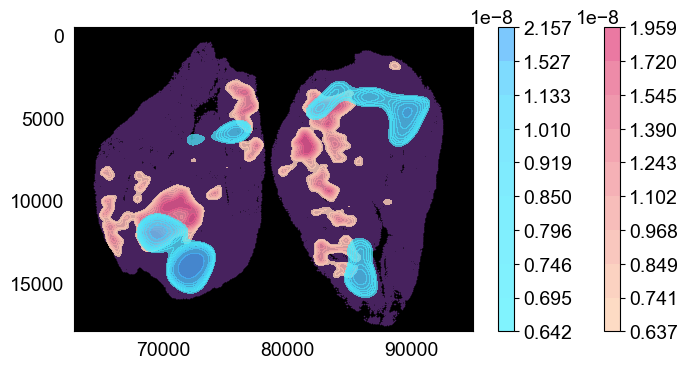

In [72]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
r_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#4AF0FE', '#44A0FD'], N=256)#blue

fig,ax = plt.subplots(figsize = (8,4))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],edgecolor = None, ax = ax ,s = 1,rasterized =True,color = '#47225E',)
sns.kdeplot(x = tb_loc[:,0], y = tb_loc[:,1],cmap=cmap,fill=True,bw_adjust = 0.25,thresh = 0.4,alpha =.8,legend=False,cbar = True,cbar_ax=None,ax = ax)

sns.kdeplot(x = known_loc[:,0], y = known_loc[:,1],cmap=r_cmap,fill=True,bw_adjust = 0.3,thresh = 0.6,alpha =.7,legend=False,cbar = True,cbar_ax=None,ax = ax)
ax.invert_yaxis()
ax.grid(False)
fig.show()

# IGH

In [73]:
color_pal1 = ["#70f3ff",  "#44cef6",  "#3eede7",  "#1685a9",  "#177cb0",  "#065279",  "#003472",
  "#4b5cc4",  "#a1afc9",  "#2e4e7e",  "#3b2e7e",  "#4a4266",  "#426666",  "#425066",  "#574266", 
  "#8d4bbb",  "#815463",  "#815476",  "#4c221b",  "#003371",  "#56004f",  "#801dae",  "#4c8dae",
  "#b0a4e3",  "#cca4e3",  "#edd1d8",  "#e4c6d0",  "#ff461f",  "#ff2d51",  "#f36838",  "#ed5736",
  "#ff4777",  "#f00056",  "#ffb3a7",  "#f47983",  "#db5a6b",  "#c93756",  "#f9906f",  "#f05654",
  "#ff2121",  "#f20c00",  "#8c4356",  "#c83c23",  "#9d2933",  "#ff4c00",  "#ff4e20",  "#f35336",
  "#dc3023",  "#ff3300",  "#cb3a56",  "#a98175",  "#b36d61",  "#ef7a82",  "#ff0097",  "#c32136",
  "#be002f",  "#c91f37",  "#bf242a",  "#c3272b",  "#9d2933",  "#60281e",  "#622a1d",  "#bce672",
  "#c9dd22",  "#bddd22",  "#afdd22",  "#a3d900",  "#9ed900",  "#9ed048",  "#96ce54",  "#00bc12",
  "#0eb83a",  "#0eb83a",  "#0aa344",  "#16a951",  "#21a675",  "#057748",  "#0c8918",  "#00e500",
  "#40de5a",  "#00e079",  "#00e09e",  "#3de1ad",  "#2add9c",  "#2edfa3",  "#7fecad",  "#a4e2c6",
  "#7bcfa6",  "#1bd1a5",  "#48c0a3",  "#549688",  "#789262",  "#758a99",  "#50616d",  "#424c50",
  "#41555d",  "#eaff56",  "#fff143",  "#faff72",  "#ffa631",  "#ffa400",  "#fa8c35",  "#ff8c31",
  "#ff8936",  "#ff7500",  "#ffb61e",  "#ffc773",  "#ffc64b",  "#f2be45",  "#f0c239",  "#e9bb1d", 
  "#d9b611",  "#eacd76",  "#eedeb0",  "#d3b17d",  "#e29c45",  "#a78e44",  "#c89b40",  "#ae7000", 
  "#ca6924",  "#b25d25",  "#b35c44",  "#9b4400",  "#9c5333",  "#a88462",  "#896c39",  "#827100",  
  "#6e511e",  "#7c4b00",  "#955539",  "#845a33"]

color_pal1 = list(set(color_pal1))
import random
random.seed(62)

color_lists = random.sample(color_pal1,k = 125)
cluster_color_dict  = dict(zip(range(1,125),color_lists))

In [74]:
bcr_isotype = 'IGH'
subdata = imudata[:,imudata.var['chain']==bcr_isotype]
clonedf = subdata.var['cdr3'].drop_duplicates().to_frame().copy()
clonedf['type'] = 'A'
addbcr = bcr[bcr['type']==bcr_isotype]['aaSeqCDR3'].drop_duplicates().to_frame().rename({'aaSeqCDR3':'cdr3'},axis = 1)
addbcr['type'] = 'B'
sub4wdata = w4[:,w4.var['chain']==bcr_isotype]
add4w = sub4wdata.var['cdr3'].drop_duplicates().to_frame().copy()
add4w['type'] = 'C'
clonedf = pd.concat([clonedf,addbcr,add4w],ignore_index=True)

In [75]:
Z = cluster_strings(clonedf['cdr3'])

In [76]:
colors_dict = {'A':'#5471AB','B':'#FAC319','C':'#D75755'}

In [77]:
threshold = 7
clusters = fcluster(Z, threshold, criterion='distance')
rZ = dendrogram(Z,no_plot=True,color_threshold= threshold+0.1,labels=clonedf['cdr3'].to_list())
clonedf['cluster'] = clusters

In [78]:
before = ""
result_list = []
counter = {'C1': -1, 'C2': -1, 'C3': -1, 'C4': -1, 'C5': -1, 'C6': -1, 'C7': -1, 'C8': -1, 'C9': -1}
step_C = 0
for now in rZ['color_list']:
    if now == 'C0':
        result_list.append(now)
    else:
        if now != before:
            step_C += 1
        result_list.append(f'C{step_C}')
        before = now
rZ['color_list'] = result_list

In [79]:
vc = clonedf['cluster'].value_counts()

In [80]:
cluster_color_dict  = dict(zip(vc[vc>1].index,color_lists))
cluster_color_dict.update(dict(zip(vc[vc==1].index,['black']*vc[vc==1].shape[0])))

In [81]:
plot_colors_dict = {
    'cdr3_type':np.array(clonedf['type'].map(colors_dict).tolist()),
    'cluster_type':np.array(clonedf['cluster'].map(cluster_color_dict).tolist())
                   }

plot_colors_legends = {'cdr3_type': 
                       {'colors':np.array(list(colors_dict.values())),'labels':list(colors_dict.keys())},
                       'cluster_type':
                       {'colors':np.array(list(cluster_color_dict.values())),'labels':list(cluster_color_dict.keys())}
                      }

0.3
1.3
['#5471AB' '#FAC319' '#D75755']
['#eacd76' '#ff461f' '#ff0097' '#ff4c00' '#c89b40' '#622a1d' '#3b2e7e'
 '#bce672' '#177cb0' '#8c4356' '#c3272b' '#cca4e3' '#815463' '#16a951'
 '#9b4400' '#ffa400' '#9ed048' '#eaff56' '#b35c44' '#1685a9' '#f00056'
 '#4c221b' '#fff143' '#c83c23' '#7bcfa6' '#44cef6' '#b36d61' '#ff8936'
 '#d3b17d' '#40de5a' '#0c8918' '#00e079' '#70f3ff' '#c91f37' '#48c0a3'
 '#4b5cc4' '#db5a6b' '#827100' '#00e500' '#e29c45' '#faff72' '#96ce54'
 '#7c4b00' '#bf242a' '#ff2121' '#003472' '#003371' '#2e4e7e' '#ff7500'
 '#f47983' '#789262' '#3de1ad' '#f0c239' '#955539' '#9ed900' '#f9906f'
 '#ffc773' '#425066' '#0eb83a' '#c32136' '#afdd22' '#c93756' '#bddd22'
 '#896c39' '#e9bb1d' '#f20c00' '#cb3a56' '#9c5333' '#56004f' '#a88462'
 '#0aa344' '#845a33' '#1bd1a5' '#eedeb0' '#ff4777' '#7fecad' '#ca6924'
 '#ff3300' '#a4e2c6' '#c9dd22' '#21a675' '#574266' '#f05654' '#ffa631'
 '#00bc12' '#b25d25' '#057748' '#2add9c' '#815476' '#2edfa3' '#8d4bbb'
 '#41555d' '#b0a4e3' '#a98175' '#6e51

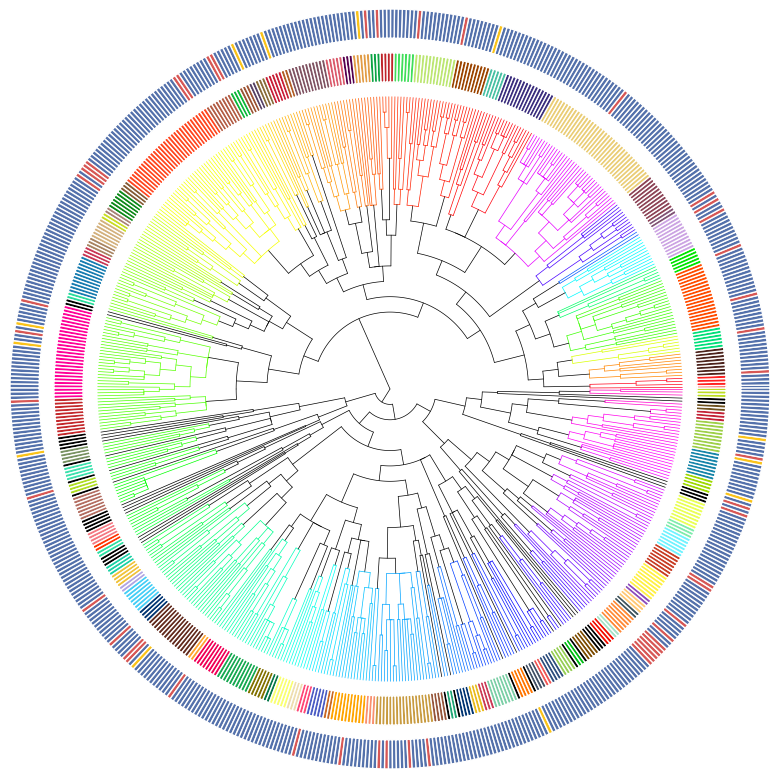

In [83]:
fig,ax = plt.subplots(figsize = (10,10))
rt.radialTreee(rZ,fontsize = 8,ax=ax,colorlabels = plot_colors_dict,colorlabels_legend = plot_colors_legends,addlabels =False)
fig.show()

In [86]:
imudata.obs['known_cluster'] = np.sum(imudata[:,imudata.var['cdr3'].isin(clusterdf[clusterdf['type'] == 'A']['cdr3'])].X,axis = 1)
imudata.obs['known_clone'] = np.sum(imudata[:,imudata.var['cdr3'].isin(clusterdf[clusterdf['type'] == 'B']['cdr3'])].X,axis = 1)

In [87]:
known_8w_adata = imudata[imudata.obs['known_cluster']>0]
known_8w_loc = known_8w_adata.obsm['spatial']
known_adata = imudata[imudata.obs['known_clone']>0]
known_loc = known_adata.obsm['spatial']

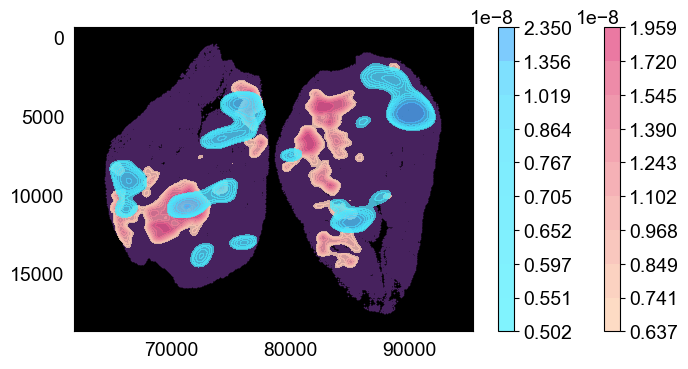

In [88]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#fed7b8', '#e24b86'], N=256)  #red
r_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#4AF0FE', '#44A0FD'], N=256)#blue

fig,ax = plt.subplots(figsize = (8,4))
ax.set_facecolor('black')
sns.scatterplot(x = totol_loc[:,0],y = totol_loc[:,1],edgecolor = None, ax = ax ,s = 1,rasterized =True,color = '#47225E',)
sns.kdeplot(x = tb_loc[:,0], y = tb_loc[:,1],cmap=cmap,fill=True,bw_adjust = 0.25,thresh = 0.4,alpha =.8,legend=False,cbar = True,cbar_ax=None,ax = ax)

sns.kdeplot(x = known_8w_loc[:,0], y = known_8w_loc[:,1],cmap=r_cmap,fill=True,bw_adjust = 0.3,thresh = 0.6,alpha =.7,legend=False,cbar = True,cbar_ax=None,ax = ax)
ax.invert_yaxis()
ax.grid(False)
fig.show()